# Home Credit Default Risk

## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [87]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, preprocessing, data_utils


### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

In [88]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Samples in our train and test datasets.

In [89]:
### Shape of the dataset
print('App train has',app_train.shape[0],'rows')
print('App test has',app_test.shape[0],'rows')

App train has 246008 rows
App test has 61503 rows


1.3. Columns in the train dataset.

In [90]:
### All columns in the training dataset
print('Las columnas son:',list(app_train.columns))

Las columnas son: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COM

1.4. First 5 records of the training dataset

In [91]:
### first 5 records in a transposed table
app_train.T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,245998,245999,246000,246001,246002,246003,246004,246005,246006,246007
SK_ID_CURR,428247,140966,407283,434300,446788,359269,239790,314509,209317,111025,...,138104,180849,308206,351537,186994,279971,279381,397830,213394,217733
TARGET,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,...,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N,N,N,N,N,N,...,N,N,N,N,Y,N,N,N,N,Y


1.5. Distribution of the target variable values: the total value count and the percentage of each value.

<AxesSubplot: >

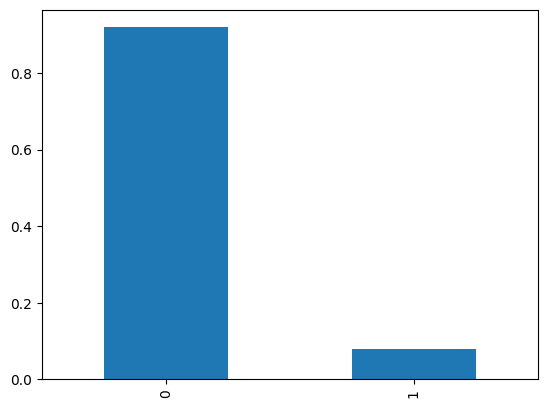

In [ ]:
### Distribution of target variable
(app_train['TARGET'].value_counts()/app_train['TARGET'].shape[0]).plot(kind='bar')


1.6. Number of columns of each data type.


In [93]:
### TODO Complete in this cell: show number of columns per data type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

1.7. For categorical variables (`object` data type), number of distinct values in each column (number of labels).


In [94]:
### Number of unique values per categorical column
categorical=app_train.dtypes[app_train.dtypes=='object']
app_train[categorical.index].nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1.8. Percentage of missing data for each column ordered by percentage descending (only the 20 columns with higher missing pct)

In [95]:
### Checking missing data
missing=pd.DataFrame(app_train.isna().sum(), columns=['Total'])
missing['Percent']=round((missing['Total']/app_train.shape[0])*100,2)

missing.sort_values(by='Percent', ascending=False)

,Total,Percent
COMMONAREA_MEDI,172189,69.99
COMMONAREA_AVG,172189,69.99
COMMONAREA_MODE,172189,69.99
NONLIVINGAPARTMENTS_MODE,171096,69.55
NONLIVINGAPARTMENTS_AVG,171096,69.55
...,...,...
NAME_FAMILY_STATUS,0,0.00
NAME_EDUCATION_TYPE,0,0.00
NAME_INCOME_TYPE,0,0.00
AMT_ANNUITY,8,0.00


#### Analyzing distribution of variables

1.9. Distribution of credit amounts.

<AxesSubplot: >

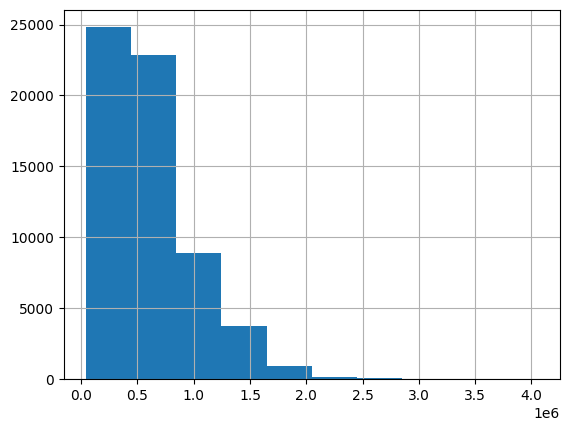

In [96]:
### Distribution of credit amounts
app_test['AMT_CREDIT'].hist()

1.10. Education level of the credit applicants, percentages of each category. Also the total counts for each category.


In [97]:
app_test.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

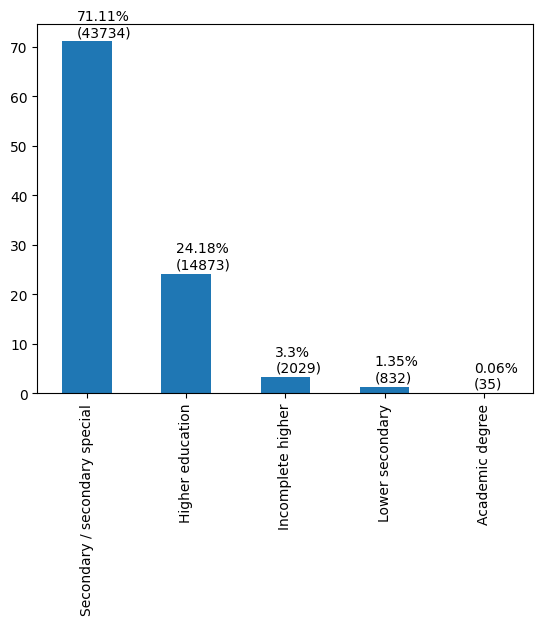

In [98]:
### Level of education plot

educ_counts = (app_test['NAME_EDUCATION_TYPE'].value_counts()/app_test['NAME_EDUCATION_TYPE'].shape[0]*100)
ax = educ_counts.plot(kind='bar')

for i, v in enumerate(educ_counts):
    ax.text(i-0.1, v+1, str(round(v, 2)) + "%\n(" + str(app_test['NAME_EDUCATION_TYPE'].value_counts()[i]) + ")", fontsize=10)

plt.show()


1.11. Distribution of ocupation of the loan applicants.

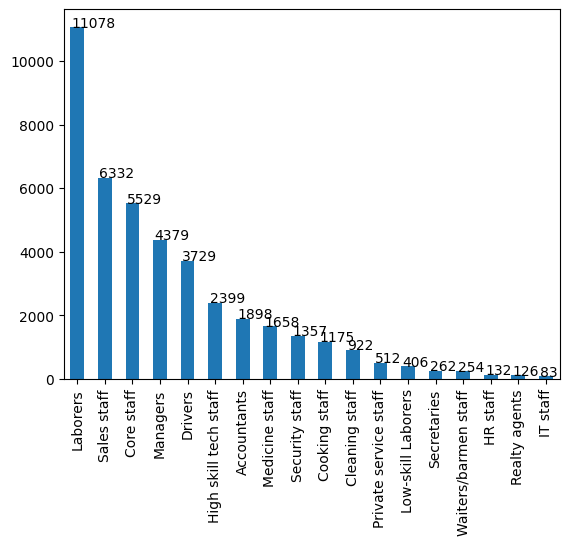

In [99]:
### Ocupation of applicants
occ_counts = app_test['OCCUPATION_TYPE'].value_counts()
ax = occ_counts.plot(kind='bar')
for i, v in enumerate(occ_counts):
    ax.text(i-0.2, v, str(v), fontsize=10)


1.12. Plot of the family status of the applicants.

<AxesSubplot: >

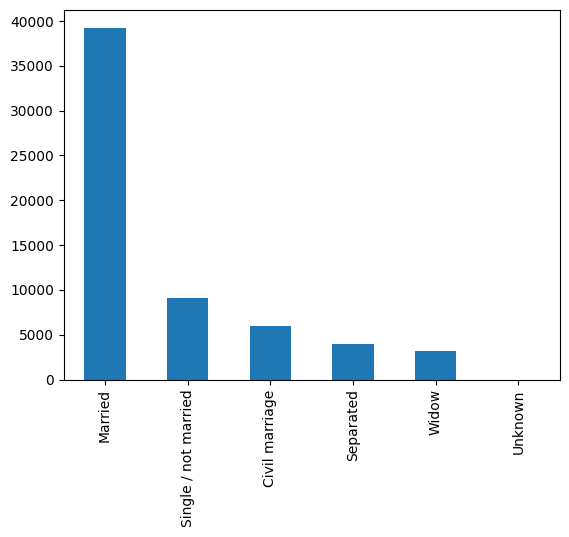

In [100]:
### Family status
(app_test['NAME_FAMILY_STATUS'].value_counts()).plot(kind='bar')

1.13. Income type of applicants grouped by the target variable.

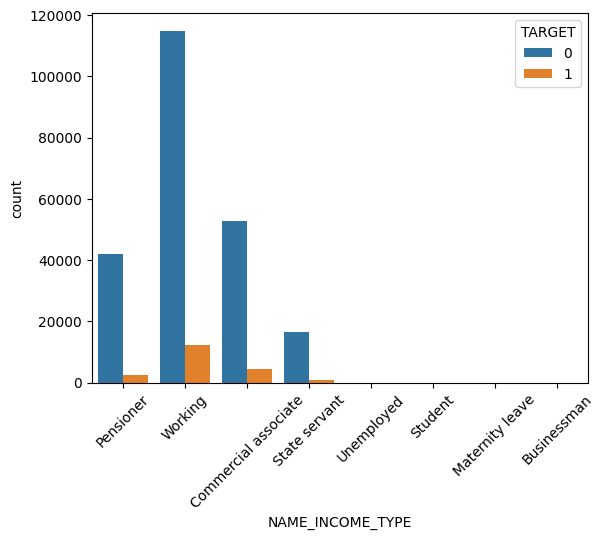

In [101]:
### Income type of applicants by target variable
sns.countplot(x="NAME_INCOME_TYPE", hue="TARGET", data=app_train)
plt.xticks(rotation=45)
plt.show()

## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, we will use the function `data_utils.get_feature_target()`


In [102]:
import importlib
importlib.reload(data_utils)
from src import data_utils

# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource we will have to evaluate the final model performance before doing your submission.

To do that, we will have to use the function `data_utils.get_train_val_sets()`

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


In [103]:
import importlib
importlib.reload(data_utils)
from src import data_utils

# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, we will code a function to make all the data pre-processing for the dataset. We have to deliver a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

This function is called `preprocessing.preprocess_data()`



**Important Note:** From now on, we must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


In [104]:
import importlib
importlib.reload(preprocessing)
from src import preprocessing

In [105]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 

Input train data shape:  (196806, 246)
Input val data shape:  (49202, 246)
Input test data shape:  (61503, 246) 

Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, we will start training simple models and will progressively move to more complex models and pipelines.

It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If we receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

In [106]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)


CPU times: total: 20.2 s
Wall time: 3.45 s


LogisticRegression(C=0.0001)

In [107]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities we will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


In [108]:
# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


In [109]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6868
Validation ROC AUC Score: 0.6835


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

**Answer:** So far, so good

In [110]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

We are gonna start working in more complex models: ensambles, particularly, we are going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train on RandomForestClassifier, print the time taken by the fit function. Default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [111]:
%%time

# Random Forest model.

rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10)
rf.fit(train_data, y_train)

CPU times: total: 3min 1s
Wall time: 24.9 s


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [112]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [113]:
# Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]


3.6. Get AUC ROC score on train and validation datasets.


With a maximum depth of 10! If I use more it overfits

In [114]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val == roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Train ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8121
Train ROC AUC Score: 0.6835


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, we have to consider the time and resources it takes to find an optimal combination of them. In the previous section we've trained a random forest classifier and saw how much it took to train it once in my PC. If we want to do hyperparameter optimization now we have to consider that we will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, we can't validate the performance of our trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here we are going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [88]:
%%time

# Random Forest model using Random Search of hyper-parameters.
#   - Please see sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - We will assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember that we will fit the model only on `train_data`.


param_distributions = {
    "n_estimators": np.random.randint(10, 100, 5),
    "max_features": ["sqrt"],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4],
    "bootstrap": [True],
}

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_distributions, n_jobs=-1, n_iter= 10)
rf_random.fit(train_data, y_train)

print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)
print(f"\n The best score across ALL searched params:\n {rf_random.best_score_: .4f}" )
print("\n The best parameters across ALL searched params:\n", rf_random.best_params_)




 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=40)

 The best score across ALL searched params:
  0.9198

 The best parameters across ALL searched params:
 {'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
CPU times: total: 21.9 s
Wall time: 7min 27s


3.8. Use the classifier to predict probabilities on the train and test data.


In [116]:
# RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val =rf_random.predict_proba(val_data)[:, 1]

3.9. Get AUC ROC score on train and validation datasets.

In [117]:
# ROC AUC Score on train_data and val_data datasets.

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f"Val ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.7992
Val ROC AUC Score: 0.7201


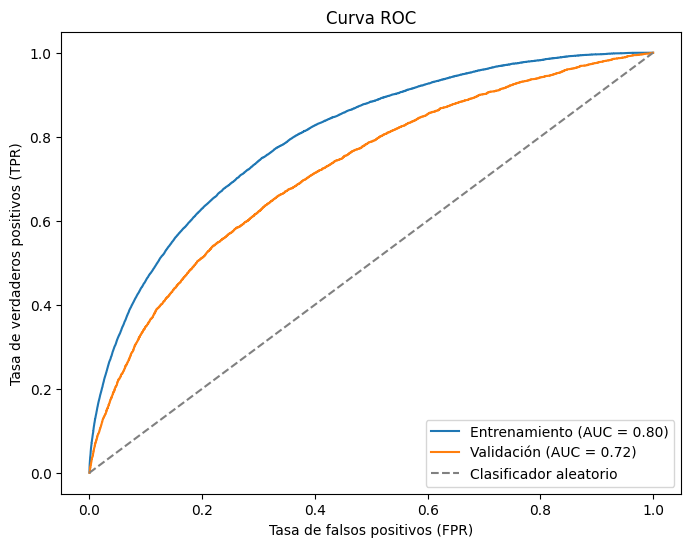

In [118]:
from sklearn.metrics import roc_curve

# Calculate the true positive rate and false positive rate for the training and validation sets
fprtrain, tprtrain, _ = roc_curve(y_train, rf_tuned_pred_train) 
fprval, tprval, _ = roc_curve(y_val, rf_tuned_pred_val)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fprtrain, tprtrain, label=f"Entrenamiento (AUC = {roc_auc_train:.2f})")
plt.plot(fprval, tprval, label=f"Validación (AUC = {roc_auc_val:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Clasificador aleatorio")

plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")

At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset

In the cells below we will do things in this order:
- Take the best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through the model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) 

Let's say the best model is called `best_credit_model_ever`, then the code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [74]:
%%time

# Use the best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").

test_preds = rf_random.predict_proba(test_data)[:, 1]
app_test["TARGET"] = test_preds
app_test.to_csv(config.DATASET_TEST, index=False)

CPU times: total: 4.5 s
Wall time: 4.82 s


## 5. Training a LightGBM Model

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. We will try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [95]:
pip install lightgbm



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [119]:
### train a LightGBM model
from lightgbm import LGBMClassifier

X_train, y_train, X_test, y_test=data_utils.get_feature_target(app_train, app_test)
X_train, X_val, y_train, y_val=data_utils.get_train_val_sets(X_train, y_train)
train_data, val_data, test_data=preprocessing.preprocess_data(X_train, X_val, X_test)

model=LGBMClassifier()
model.fit(train_data, y_train)

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 

Input train data shape:  (196806, 246)
Input val data shape:  (49202, 246)
Input test data shape:  (61503, 246) 



LGBMClassifier()

In [120]:
# Class 1
lgbm_train_predict=model.predict_proba(train_data)[:,1]
lgbm_val_predict=model.predict_proba(val_data)[:,1]

In [81]:
# Metrics
roc_auc_train_lgbm=roc_auc_score(y_true=y_train, y_score=lgbm_train_predict)
print(f"Train ROC aUC Score: {roc_auc_train_lgbm:.4f}")

roc_auc_val_lgbm=roc_auc_score(y_true=y_val, y_score=lgbm_val_predict)
print(f"Val ROC aUC Score: {roc_auc_val_lgbm:.4f}")

Train ROC aUC Score: 0.8029
Val ROC aUC Score: 0.7476


### Using Scikit Learn Pipelines 

5.2. So far we have created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and we don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help with that, here we will use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process the data.

In [121]:
import pandas as pd

ordinal_columns=list()
ohe_columns=list()
for col in app_train.select_dtypes(include='object').columns:
    if app_train[col].nunique()==2:
        ordinal_columns.append(col)
    else:
        ohe_columns.append(col)
print(ordinal_columns)
print(ohe_columns)

['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [122]:
numerical_features = app_train.select_dtypes(include='number').columns.tolist()
print(numerical_features)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEAR

In [148]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder


encoding = ColumnTransformer([
    ('binary', OrdinalEncoder(), ordinal_columns),
    ('multiple', OneHotEncoder(sparse_output=False), ohe_columns)
], remainder='passthrough')

processor_pipeline = Pipeline([
    ('encoding', encoding),
    ('imputing', SimpleImputer(strategy='median')),
    ('scaling', MinMaxScaler())
])

lgbm_pipeline = Pipeline([
    ('preprocessor', processor_pipeline),
    ('model', LGBMClassifier(n_jobs=-1))
])

lgbm_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoding',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('binary',
                                                                   OrdinalEncoder(),
                                                                   ['NAME_CONTRACT_TYPE',
                                                                    'FLAG_OWN_CAR',
                                                                    'FLAG_OWN_REALTY',
                                                                    'EMERGENCYSTATE_MODE']),
                                                                  ('multiple',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['CODE_GENDER',
                                                                    'NAME_TYPE_SUITE',
                                                                    'NAME_INCOME_TYPE',
                                                                    'NAME_EDUCATION_TYPE',
                                                                    'NAME_FAMILY_STATUS',
                                                                    'NAME_HOUSING_TYPE',
                                                                    'OCCUPATION_TYPE',
                                                                    'WEEKDAY_APPR_PROCESS_START',
                                                                    'ORGANIZATION_TYPE',
                                                                    'FONDKAPREMONT_MODE',
                                                                    'HOUSETYPE_MODE',
                                                                    'WALLSMATERIAL_MODE'])])),
                                 ('imputing', SimpleImputer(strategy='median')),
                                 ('scaling', MinMaxScaler())])),
                ('model', LGBMClassifier())])

In [150]:
# Testin the pipeline

# Class 1
lgbm_train_predict=lgbm_pipeline.predict_proba(X_train)[:,1]
lgbm_val_predict=lgbm_pipeline.predict_proba(X_val)[:,1]

# Metrics
roc_auc_train_lgbm=roc_auc_score(y_true=y_train, y_score=lgbm_train_predict)
print(f"Train ROC aUC Score: {roc_auc_train_lgbm:.4f}")

roc_auc_val_lgbm=roc_auc_score(y_true=y_val, y_score=lgbm_val_predict)
print(f"Val ROC aUC Score: {roc_auc_val_lgbm:.4f}")

Train ROC aUC Score: 0.8073
Val ROC aUC Score: 0.7527


In [135]:
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoding',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('binary',
                                                                   OrdinalEncoder(),
                                                                   ['NAME_CONTRACT_TYPE',
                                                                    'FLAG_OWN_CAR',
                                                                    'FLAG_OWN_REALTY',
                                                                    'EMERGENCYSTATE_MODE']),
                                                                  ('multiple',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['CODE_GENDER',
                                                                    'NAME_TYPE_SUITE',
                                                                    'NAME_INCOME_TYPE',
                                                                    'NAME_EDUCATION_TYPE',
                                                                    'NAME_FAMILY_STATUS',
                                                                    'NAME_HOUSING_TYPE',
                                                                    'OCCUPATION_TYPE',
                                                                    'WEEKDAY_APPR_PROCESS_START',
                                                                    'ORGANIZATION_TYPE',
                                                                    'FONDKAPREMONT_MODE',
                                                                    'HOUSETYPE_MODE',
                                                                    'WALLSMATERIAL_MODE'])])),
                                 ('imputing', SimpleImputer(strategy='median')),
                                 ('scaling', MinMaxScaler())])),
                ('model', LGBMClassifier())])